# Data Loading

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

# Data Cleaning

In [2]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# Data Pre-processing

In [3]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [4]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

# Time Based Sorting

In [5]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Finding optimal number of Clusters

In [7]:
#function to get optimal number of clusters
from sklearn.cluster import KMeans
def getOptimalNoOfClusters(vector):
    loss = {}
    for k in range(1, 20):
        kmeans = KMeans(n_clusters=k).fit(vector)
        loss[k] = kmeans.inertia_ 

    plt.figure()
    plt.plot(list(loss.keys()), list(loss.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("loss")
    plt.show()

# K-means clustering

In [8]:
#function to apply k-means++ model
from sklearn.cluster import KMeans
def applyKMeansclustering(vector,n_clust):
    kmeans = KMeans(n_clusters=n_clust,n_jobs=-1)
    kmeans  = kmeans.fit(vector)
    return kmeans

# Retrieving data from cluster

In [13]:
 #function to retrieve data from clusters
from wordcloud import WordCloud, STOPWORDS 
def retrieveDataFromCluster(cluster,feature_names):
    stopwords = set(STOPWORDS)
    order_centroids = cluster.cluster_centers_.argsort()[:, ::-1]
    for i in range(4):
        text = ' '
        print("\n Cluster %d:" % i),
        for ind in order_centroids[i, :100]:
            text = text + feature_names[ind]+' '
        wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, 
                min_font_size = 10).generate(text) 
        # plot the WordCloud image                        
        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.show() 

# Featurization using BOW

In [10]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import Imputer
# =============================================================================================
#supress warnings
warnings.filterwarnings("ignore")

#BOW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(sample_data)
bow_vector = count_vect.transform(sample_data)
bow_vector = bow_vector.toarray()

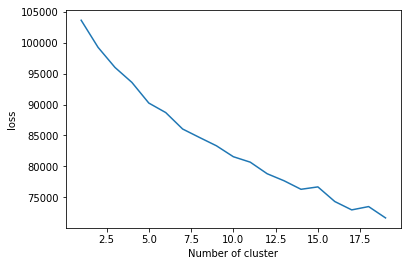

In [11]:
#finding optimal number of clusters
getOptimalNoOfClusters(bow_vector)

# kmeans clustering with optimal no_of_clusters - BOW


 Cluster 0:


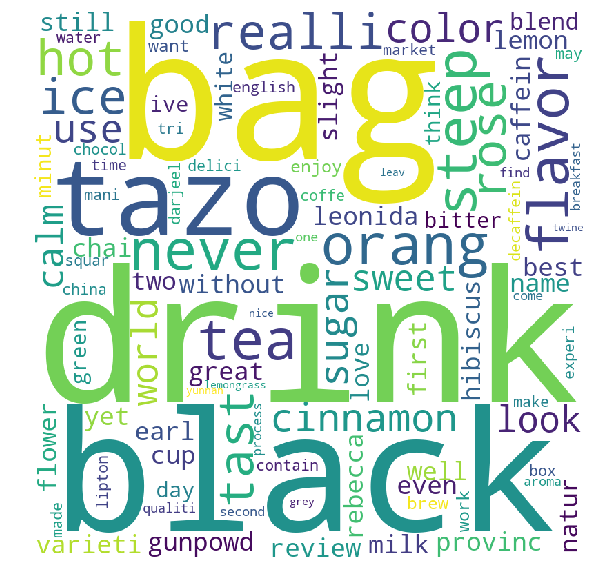


 Cluster 1:


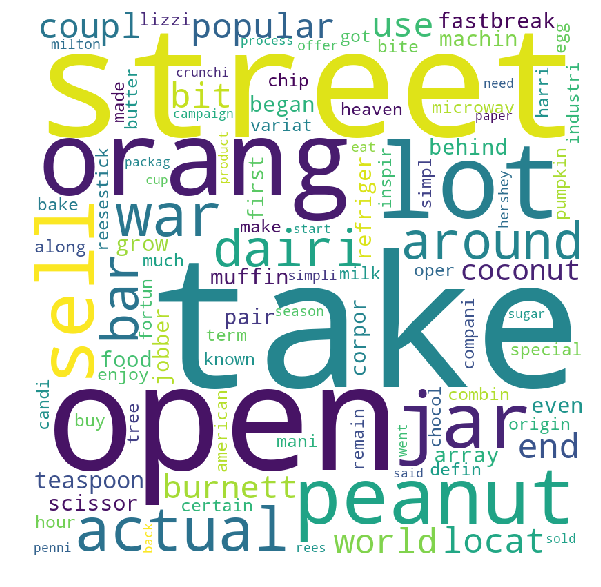


 Cluster 2:


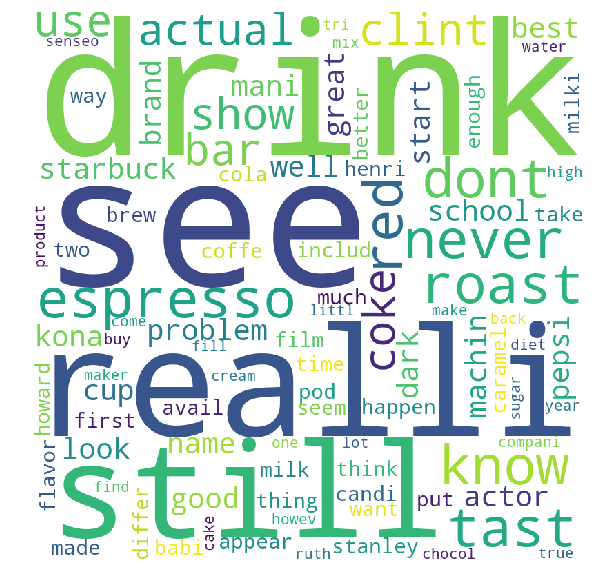


 Cluster 3:


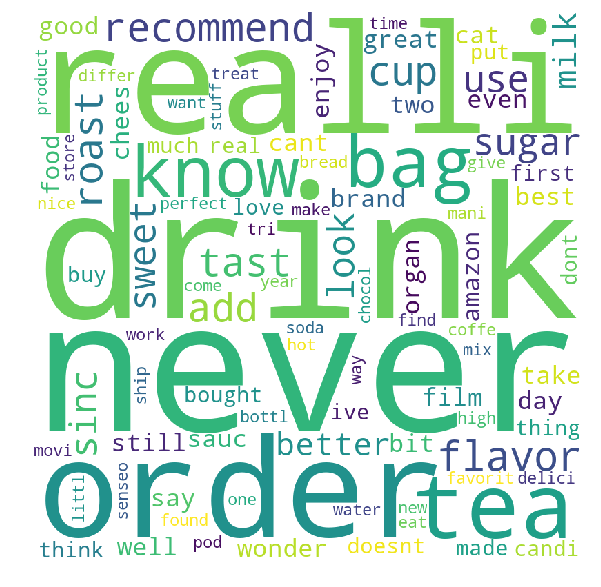

In [14]:
#apply k-means clutering with optimal clusters and retrieve data from clusters
feature_names =count_vect.get_feature_names()
bow_cluster = applyKMeansclustering(bow_vector,4)
retrieveDataFromCluster(bow_cluster,feature_names)

# Featurization using TFIDF

In [15]:
#tfidf vectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit(sample_data)
tfidf_vector = final_tf_idf.transform(sample_data)
tfidf_vector = tfidf_vector.toarray()

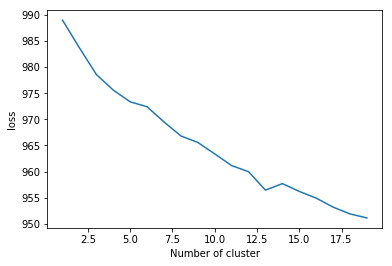

In [21]:
#finding optimal number of clusters
getOptimalNoOfClusters(tfidf_vector)

# kmeans clustering with optimal no_of_clusters - TFIDF


 Cluster 0:


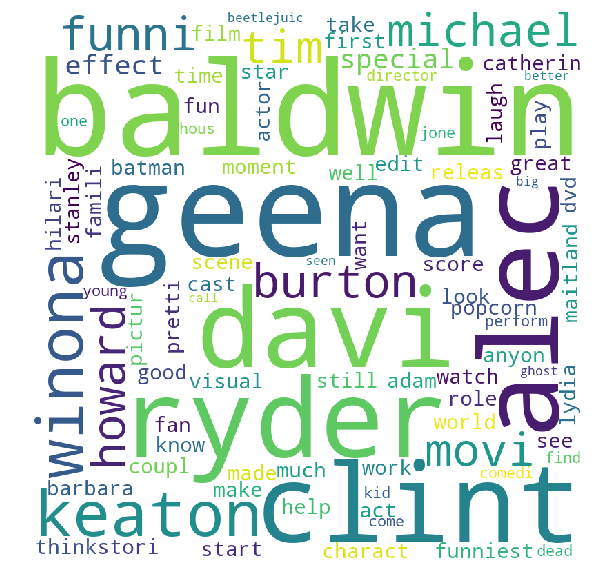


 Cluster 1:


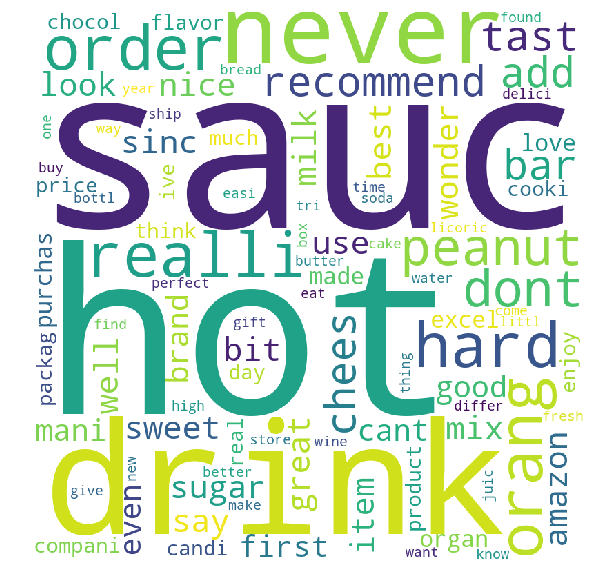


 Cluster 2:


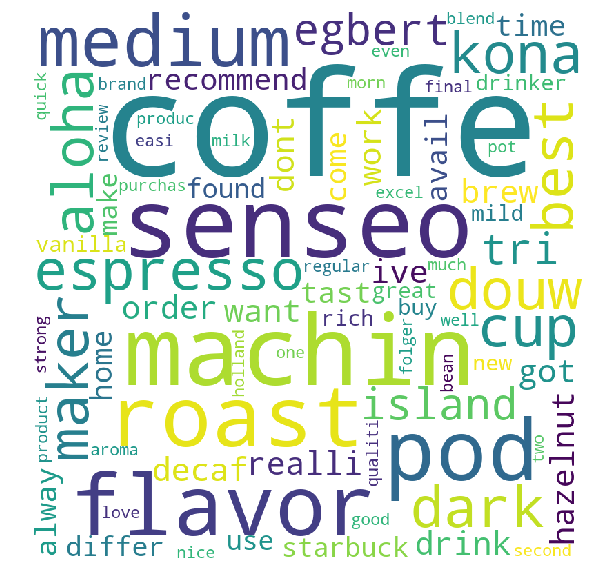


 Cluster 3:


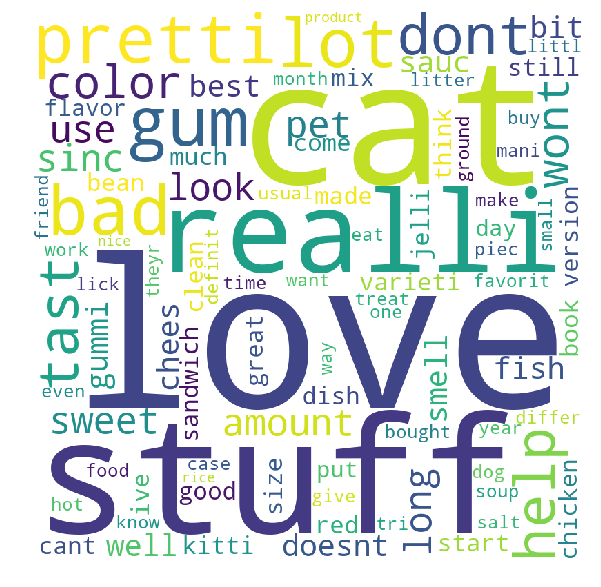

In [22]:
#apply k-means clutering with optimal clusters and retrieve data from clusters
feature_names =final_tf_idf.get_feature_names()
tfidf_cluster = applyKMeansclustering(tfidf_vector,5)
retrieveDataFromCluster(tfidf_cluster,feature_names)

# Featurization using AvgW2Vec

In [16]:

# Train your own Word2Vec model using sample_data
import gensim
warnings.filterwarnings("ignore")

i=0
list_of_sent_sample_data=[]
for sent in sample_data:
    sent = sent.decode('utf-8')
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_sample_data.append(filtered_sentence)

In [17]:
w2v_model=gensim.models.Word2Vec(list_of_sent_sample_data,min_count=1,size=50, workers=4) 

In [18]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_sample_data = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_sample_data: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_sample_data.append(sent_vec)
avgw2v_vector = sent_vectors_sample_data

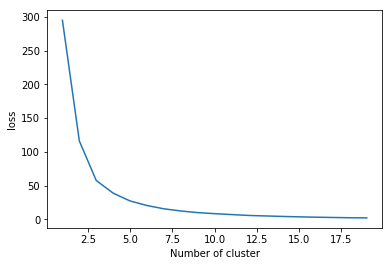

In [19]:
#finding optimal number of clusters
getOptimalNoOfClusters(avgw2v_vector)

# kmeans clustering with optimal no_of_clusters - AVGW2V


 Cluster 0:


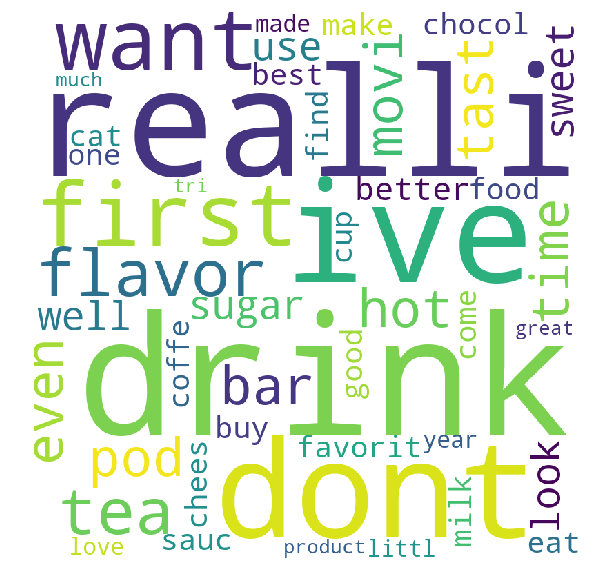


 Cluster 1:


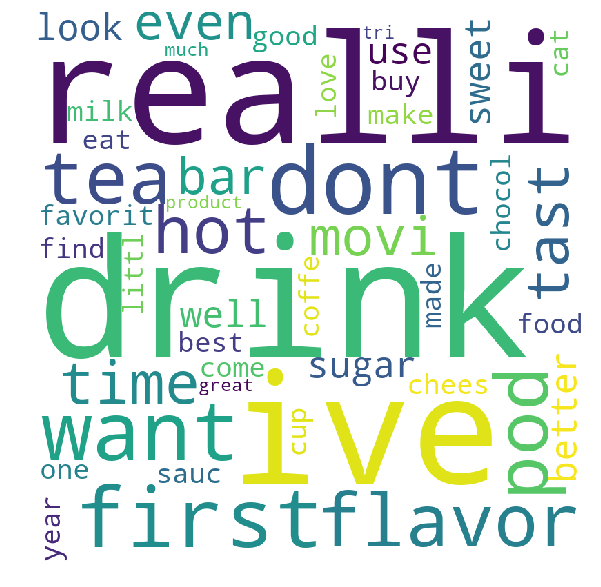


 Cluster 2:


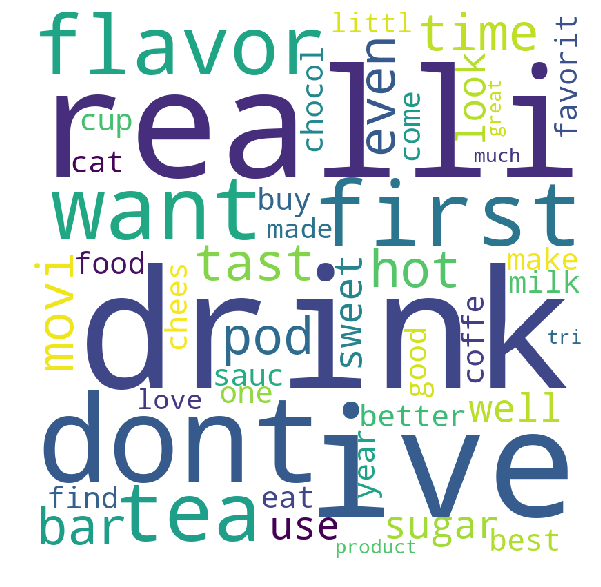


 Cluster 3:


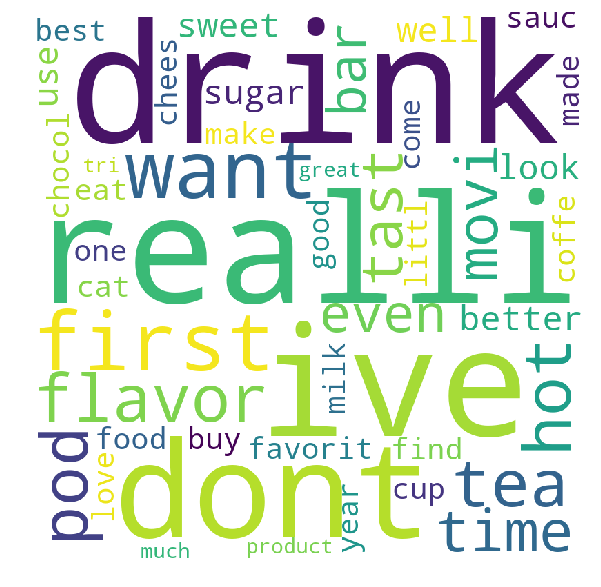

In [20]:
feature_names = w2v_model.wv.index2word
avgw2v_cluster = applyKMeansclustering(avgw2v_vector,4)
retrieveDataFromCluster(avgw2v_cluster,feature_names)

# Featurization using TFIDFW2Vec

In [23]:
tf_idf_sample_data_vect = TfidfVectorizer()
tf_idf_sample_data_vect.fit(sample_data)
final_tf_idf_sample_data_vect = tf_idf_sample_data_vect.transform(sample_data)

In [24]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_sample_data_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_sample_data_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_sample_data: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try: 
            
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_sample_data_vect[row, tfidf_feat.index(word)]
            sent_vec +=(vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_sample_data_vectors.append(sent_vec)
    row += 1
tfidfw2v_vector = tfidf_sent_sample_data_vectors

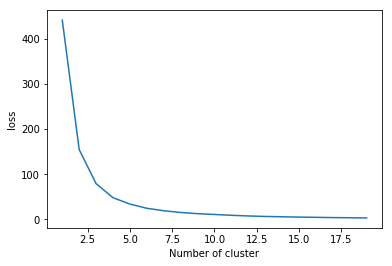

In [25]:
#finding optimal number of clusters
getOptimalNoOfClusters(tfidfw2v_vector)

# kmeans clustering with optimal no_of_clusters - TFIDFW2V


 Cluster 0:


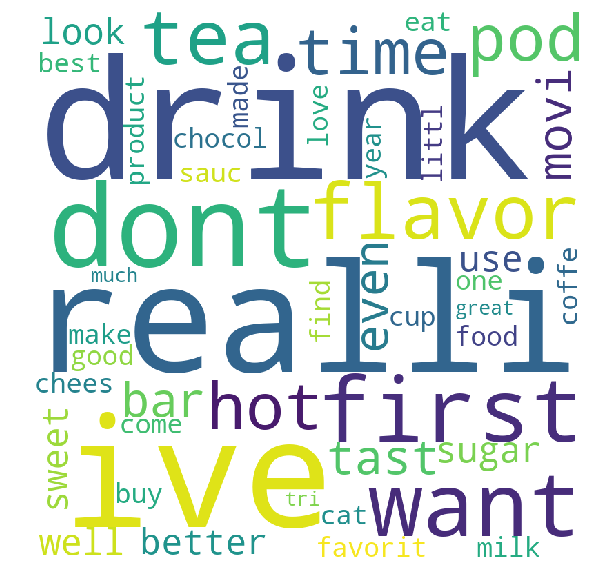


 Cluster 1:


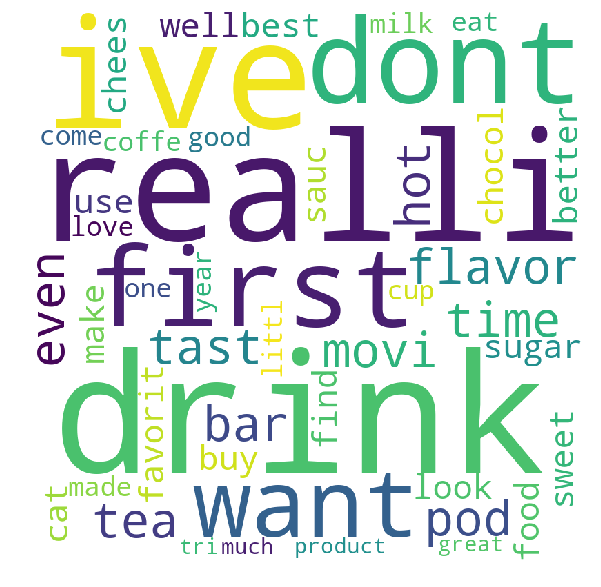


 Cluster 2:


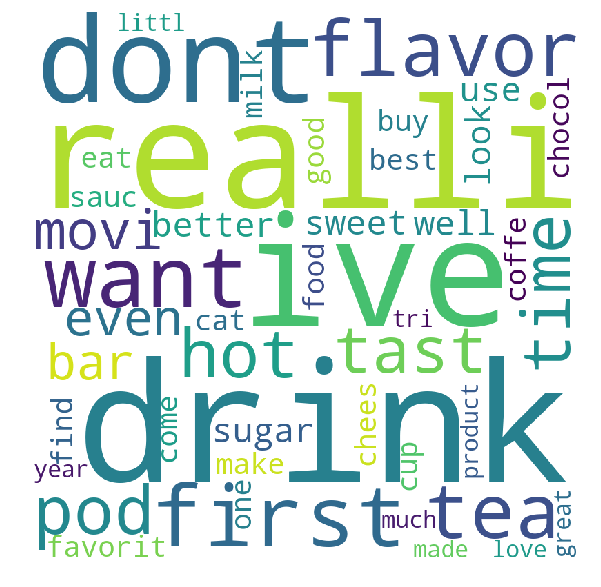


 Cluster 3:


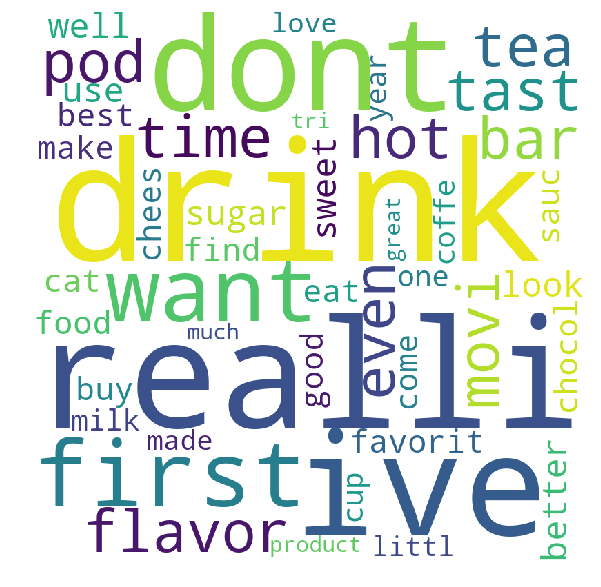

In [26]:
feature_names = w2v_model.wv.index2word
tfidfw2v_vector = applyKMeansclustering(tfidfw2v_vector,4)
retrieveDataFromCluster(tfidfw2v_vector,feature_names)

# Conclusion

In [1]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ['Featurization', 'Hyperparameter(n_cluster)']
t.add_row(["BOW","4"])
t.add_row(["TFIDF","5"])
t.add_row(["AVGW2V","4"])
t.add_row(["TFIDFW2V","4"])
print(t)

+---------------+---------------------------+
| Featurization | Hyperparameter(n_cluster) |
+---------------+---------------------------+
|      BOW      |             4             |
|     TFIDF     |             5             |
|     AVGW2V    |             4             |
|    TFIDFW2V   |             4             |
+---------------+---------------------------+
